# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is montly_champagne_sales

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## 02 - Load Data
Let's start by loading the time series of the challenge

In [16]:
df_original = pd.read_csv('./data/monthly_champagne_sales.csv',parse_dates=["Month"],index_col=0)
df_original.head()
df = df_original.copy()
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


👉 Convert dataframe with datetime objects as index to make it look like this
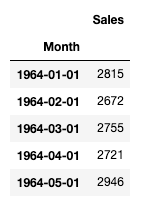

In [4]:
ts = df_original.Sales

## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

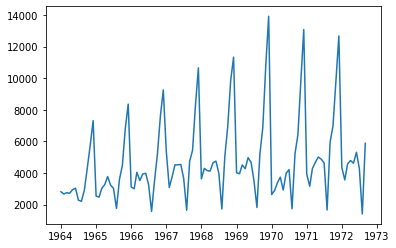

In [5]:
plt.plot(ts)

In [6]:
ts

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Sales, Length: 105, dtype: int64

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

additive


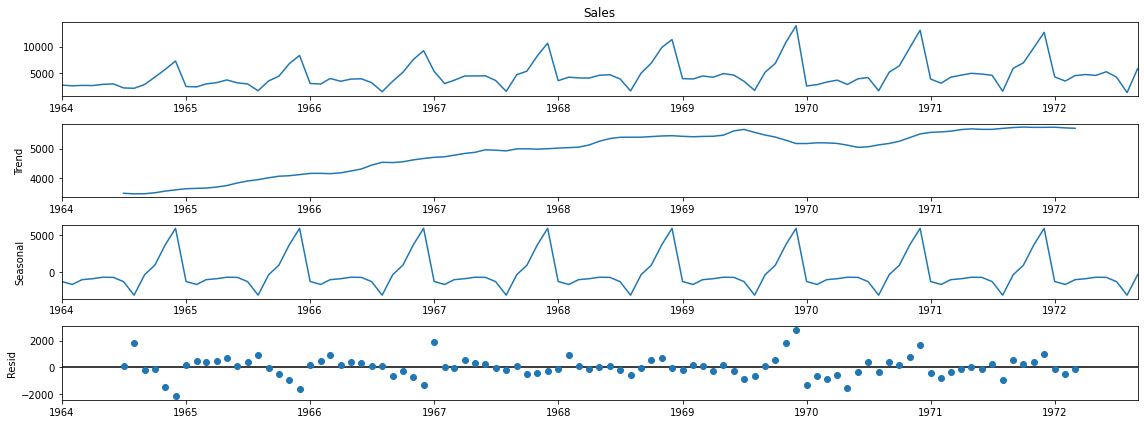

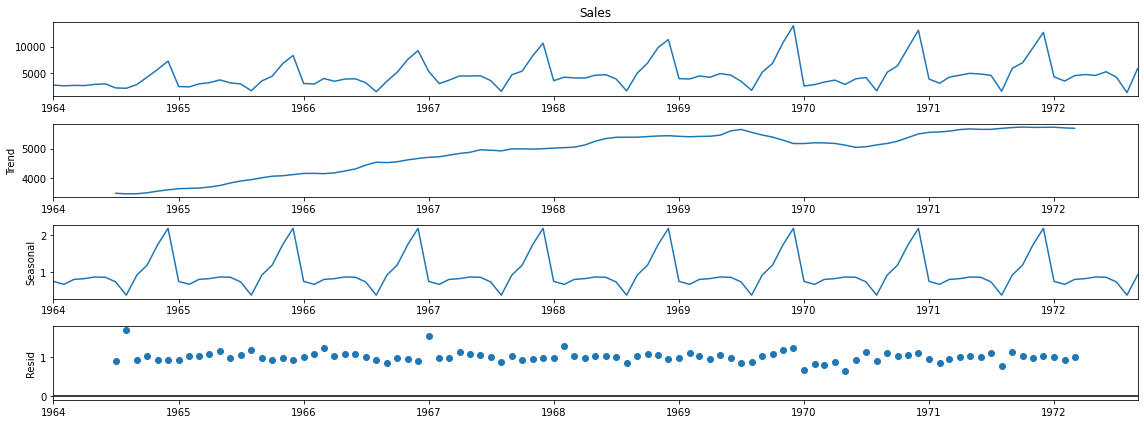

In [7]:
plt.rc("figure", figsize=(16,6))
print('additive')
seasonal_decompose(ts,model="additive", period=12).plot();
seasonal_decompose(ts,model= "multiplicative", period=12).plot();

👉 De-seasonalize this time serie using the decomposition of your choice

<AxesSubplot:xlabel='Month'>

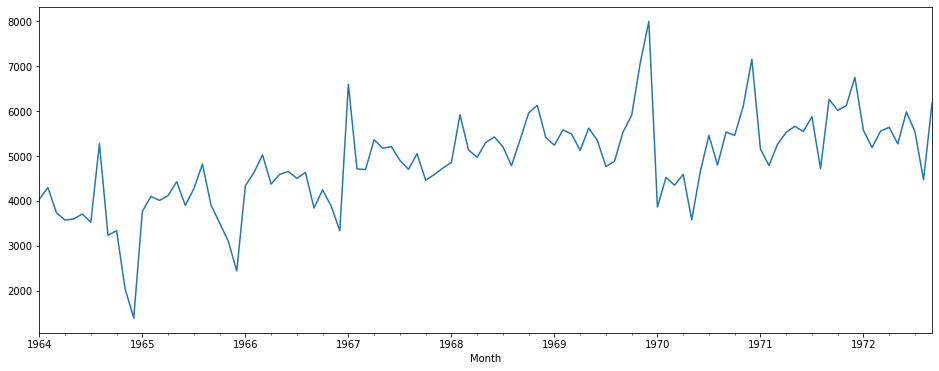

In [8]:
decompose = seasonal_decompose(ts,model="additive", period=12)
deseasonal =  (ts - decompose.seasonal)
deseasonal.plot()

<AxesSubplot:xlabel='Month'>

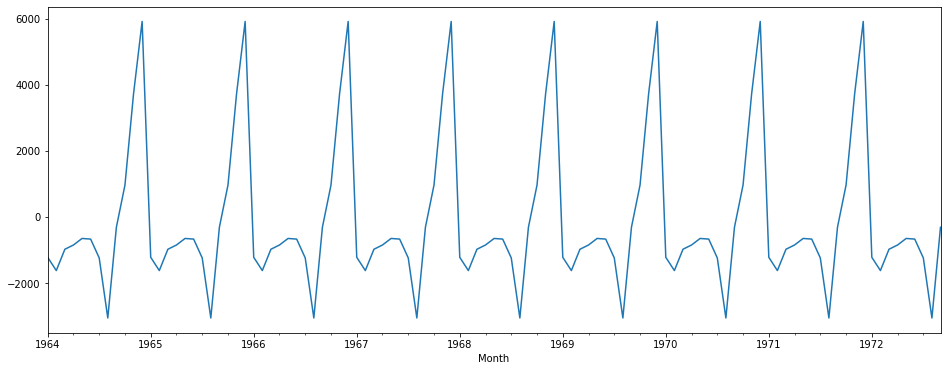

In [9]:
decompose.seasonal.plot()

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [17]:
df_train = df[:'1969-12-31']#['Sales']
df_test = df['1970-01-01':]#['Sales']

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [11]:
adfuller(df['Sales'], autolag='AIC')

(-1.8335930563276175,
 0.3639157716602477,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

<h2>0.36 is a too big p-value for our timeserie to be stationary</h2>

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

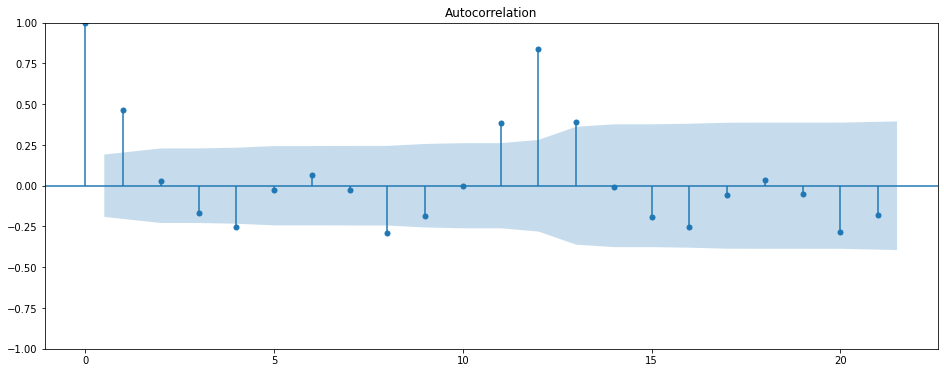

In [12]:
plot_acf(df.Sales);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

<AxesSubplot:xlabel='Month'>

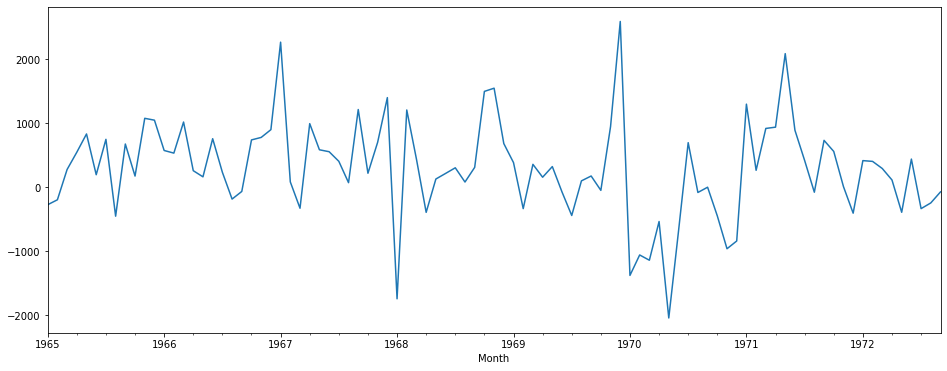

In [13]:
serie_diff12 = df.Sales.diff(12).dropna()

serie_diff12.plot()



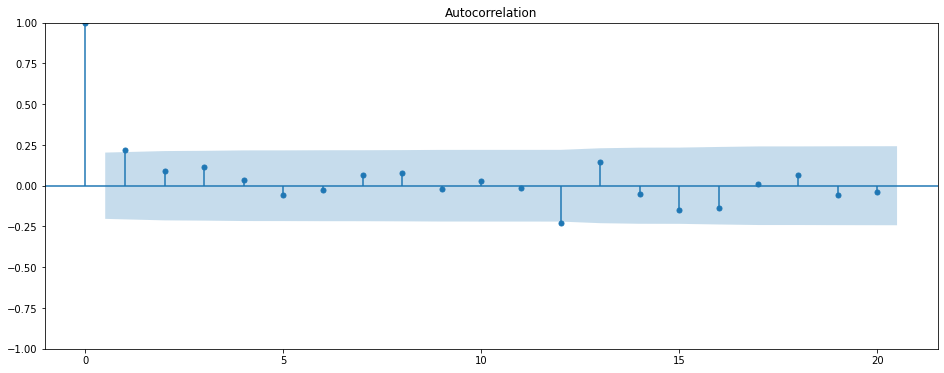

In [14]:
plot_acf(df.Sales.diff(12).dropna());

In [15]:
adfuller(serie_diff12, autolag='AIC')

(-7.626619157213164,
 2.060579696813685e-11,
 0,
 92,
 {'1%': -3.503514579651927,
  '5%': -2.893507960466837,
  '10%': -2.583823615311909},
 1294.7753384560438)

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

In [16]:
serie_diff12.diff(1).dropna()

adfuller(serie_diff12.diff(1).dropna(), autolag='AIC')

(-4.427713497307504,
 0.0002650462849293473,
 11,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 1290.6965709705498)

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

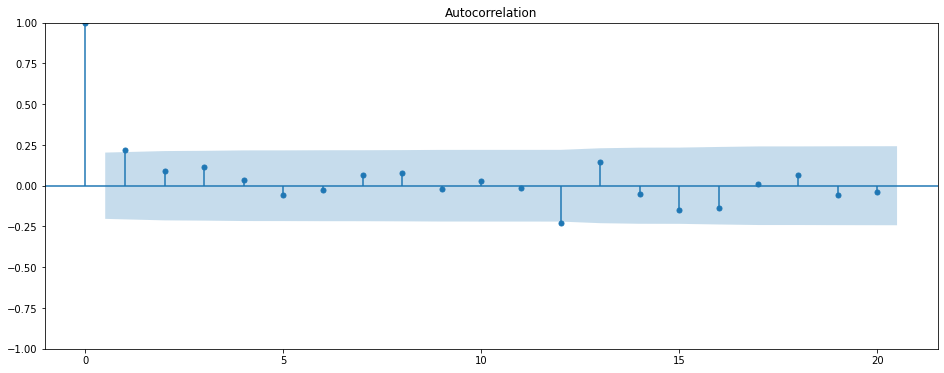

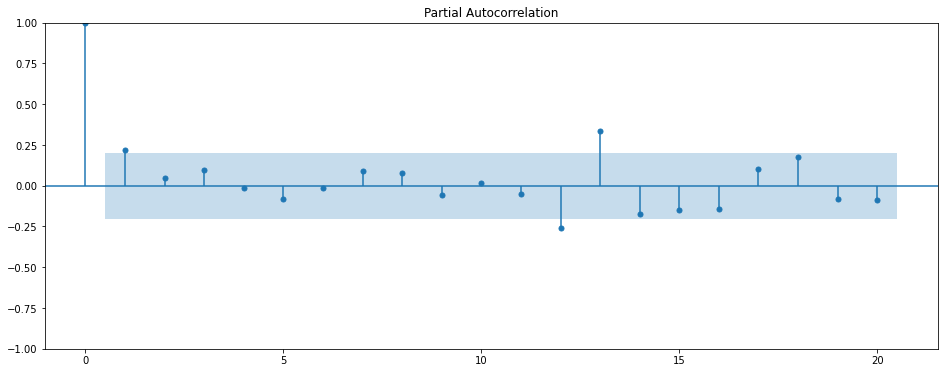

In [17]:
plot_acf(serie_diff12)
# MA => q=1 ou 0
plot_pacf(serie_diff12);
# AR => p = 0 ou 1


☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [22]:
import pmdarima as pm
auto_model = pm.auto_arima(df_train['Sales'], start_p=0, start_q=0,
                             max_p=2, max_q=2,
                             start_P=0,
                             D=1,
                             start_Q=0,
                             max_P=1,
                             max_D=1,
                             max_Q=1,
                             d=0,
                             m=12,
                             seasonal=True, 
                             njobs=-1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True  # don't want convergence warnings
                             )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.10 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.555 seconds


In [23]:
dir(auto_model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_exog',
 '_check_feature_names',
 '_check_n_features',
 '_fit',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_warn_for_older_version',
 'aic',
 'aicc',
 'arima_res_',
 'arparams',
 'arroots',
 'bic',
 'bse',
 'conf_int',
 'df_model',
 'df_resid',
 'fit',
 'fit_predict',
 'fit_with_exog_',
 'get_params',
 'hqic',
 'maparams',
 'maroots',
 'maxiter',
 'method',
 'nobs_',
 'oob',
 'oob_',
 'oob_preds_',
 'order',
 'out_of_sample_size',
 'params',
 'pkg_version_',


In [24]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -475.126
Date:                  Sat, 08 Jan 2022   AIC                            954.252
Time:                          22:40:23   BIC                            958.441
Sample:                               0   HQIC                           955.891
                                   - 72                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    447.0500     87.035      5.136      0.000     276.464     617.636
sigma2      4.423e+05   5.54e+04      7.979      0.000    3.34e+05    5.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                15.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             0.34
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

In [44]:
type(auto_model)

pmdarima.arima.arima.ARIMA

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [57]:
preds, conf_int = auto_model.predict(n_periods=df_test.shape[0], return_conf_int=True)
central = pd.Series(preds,index=df_test.index)
lower = pd.Series(conf_int[:,0],index=df_test.index)
upper = pd.Series(conf_int[:,1],index=df_test.index)

👇 Run the cell below to plot your predictions against reality

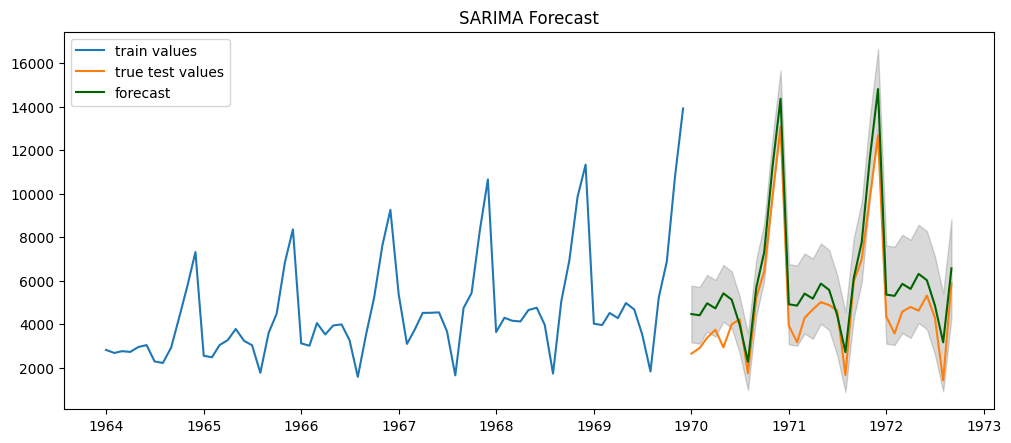

In [59]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

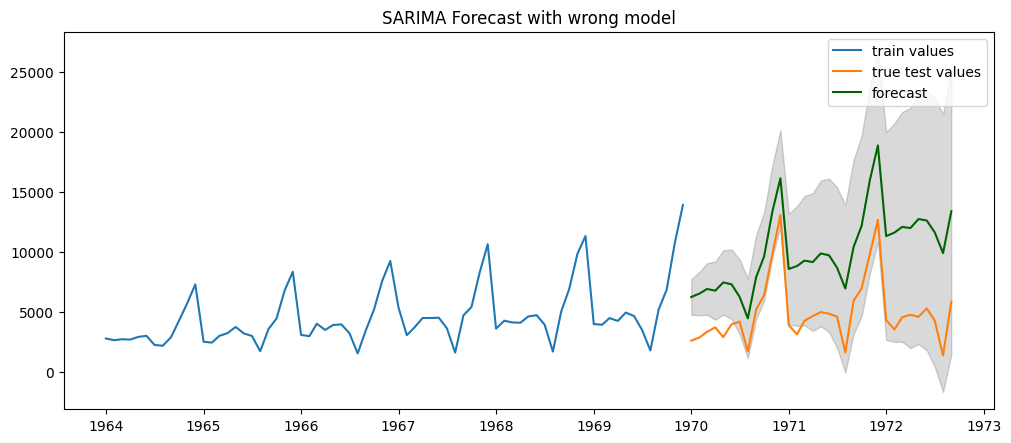

In [66]:
model_2 = pm.arima.ARIMA((1,1,0),(1,1,0,12))
model_2.fit(df_train['Sales'])

preds, conf_int = model_2.predict(n_periods=df_test.shape[0], return_conf_int=True)
central = pd.Series(preds,index=df_test.index)
lower = pd.Series(conf_int[:,0],index=df_test.index)
upper = pd.Series(conf_int[:,1],index=df_test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                lower, 
                upper, 
                color='k', alpha=.15)

plt.title("SARIMA Forecast with wrong model")
plt.legend()
plt.show()

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only with 

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [2]:
import pandas as pd
df_try = pd.DataFrame(range(15))
for i in range(12):
    df_try[i] = df_try[0].shift(i)
df_try.columns = df_try.columns+1
df_try

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,6,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
7,7,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN
8,8,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN
9,9,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN


In [118]:
def make_shifted_12(df):
    for i in range(12):
        df[i] = df[0].shift(i)
    df.columns = df.columns+1
    return df.dropna()
    
test0 = pd.DataFrame(range(15))
make_shifted_12(test0)


,1,2,3,4,5,6,7,8,9,10,11,12
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,6,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
7,7,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN
8,8,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN,NaN
9,9,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0,NaN,NaN


In [119]:
df_original = pd.read_csv('./data/monthly_champagne_sales.csv',parse_dates=["Month"],index_col=0)
df_original.head()
df = df_original.copy()
df.columns = [0]
df = make_shifted_12(df)

df_train = df[:'1969-12-31']#['Sales']
df_test = df['1970-01-01':]#['Sales']

In [113]:
# Keep track of test_indexes
test_indexes = df_test.index

In [21]:
test_indexes

DatetimeIndex(['1970-01-01', '1970-02-01', '1970-03-01', '1970-04-01',
               '1970-05-01', '1970-06-01', '1970-07-01', '1970-08-01',
               '1970-09-01', '1970-10-01', '1970-11-01', '1970-12-01',
               '1971-01-01', '1971-02-01', '1971-03-01', '1971-04-01',
               '1971-05-01', '1971-06-01', '1971-07-01', '1971-08-01',
               '1971-09-01', '1971-10-01', '1971-11-01', '1971-12-01',
               '1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [112]:
# Create X, y
def get_X_y(df):
    y = df[[1]]
    X = df.drop(columns=1)
    return X,y
X_train, y_train = get_X_y(df_train)
X,y=get_X_y(df)

In [114]:
X


,2,3,4,5,6,7,8,9,10,11,12
Month,,,,,,,,,,,
1964-12-01,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0
1965-01-01,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0
1965-02-01,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0
1965-03-01,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0
1965-04-01,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0
...,...,...,...,...,...,...,...,...,...,...,...
1972-05-01,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0,4874.0
1972-06-01,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0
1972-07-01,5312.0,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0


In [23]:
y

,1
Month,
1964-12-01,7312
1965-01-01,2541
1965-02-01,2475
1965-03-01,3031
1965-04-01,3266
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [115]:
df

,1,2,3,4,5,6,7,8,9,10,11,12
Month,,,,,,,,,,,,
1964-12-01,7312,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0
1965-01-01,2541,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0
1965-02-01,2475,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0
1965-03-01,3031,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0
1965-04-01,3266,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1972-05-01,4618,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0,4874.0
1972-06-01,5312,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0
1972-07-01,4298,5312.0,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0


👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [26]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(max_depth=2, random_state=0)

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [66]:
# For each predictor, design a method to evaluate its performance on the test set:
import numpy as np
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true.loc[_indx]
        current_ground_truth_features = full_X.loc[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.values.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X)

In [68]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.5591491575584938

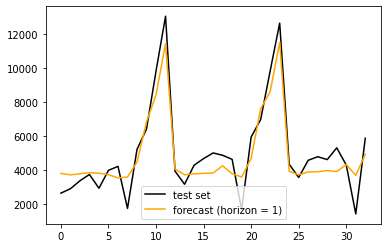

In [70]:
import matplotlib.pyplot as plt
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


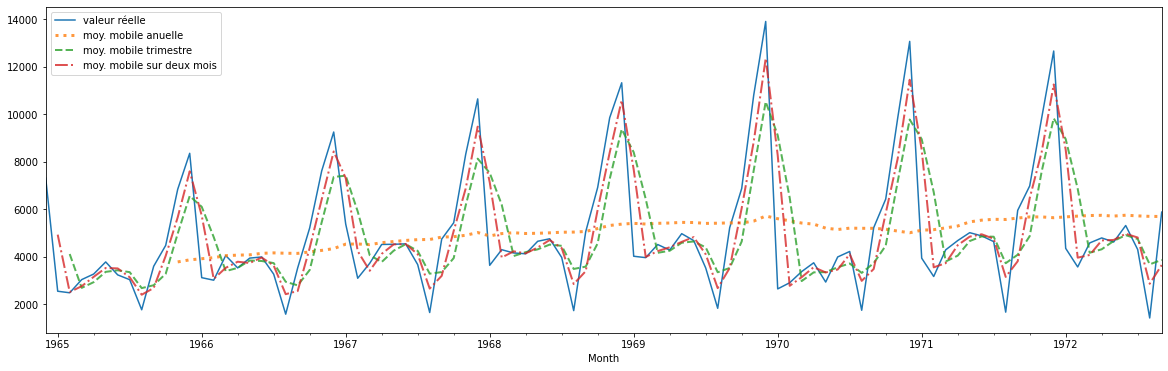

In [87]:
# Extract the trend using a well chosen moving average
plt.figure(figsize=(20,6))
df[1].plot(label = 'valeur réelle')
df[1].rolling(window=12).agg('mean').plot(label='moy. mobile anuelle',lw=3,ls=':',alpha=0.8)
df[1].rolling(window=3).agg('mean').plot(label = 'moy. mobile trimestre',lw=2,ls='--',alpha=0.8)
df[1].rolling(window=2).agg('mean').plot(label = 'moy. mobile sur deux mois',lw =2,ls ='-.',alpha = 0.8 )
plt.legend()

In [121]:
df['moy_mobile_Y']=df[1].rolling(window=12).agg('mean')
df['moy_mobile_2M']=df[1].rolling(window=2).agg('mean')
df['moy_mobile_3M']=df[1].rolling(window=3).agg('mean')

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

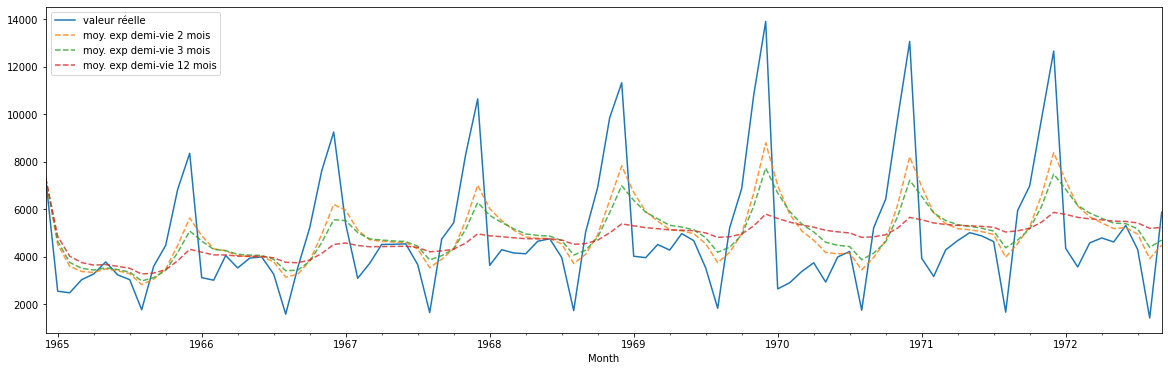

In [101]:
plt.figure(figsize=(20,6))
df[1].plot(label = 'valeur réelle')
for i in [2,3,12]:
    df[1].ewm(halflife=i).mean().plot(label = f'moy. exp demi-vie {i} mois',ls='--',alpha=0.8)
plt.legend()

In [122]:
for i in [2,3,12]:
    df[f'moy_exp_halflife{i}M']= df[1].ewm(halflife=i).mean()

In [124]:
df.dropna(inplace=True)
df

,1,2,3,4,5,6,7,8,9,10,11,12,moy_mobile_Y,moy_mobile_2M,moy_mobile_3M,moy_exp_halflife2M,moy_exp_halflife3M,moy_exp_halflife12M
Month,,,,,,,,,,,,,,,,,,
1964-12-01,7312,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,3478.166667,6538.0,5792.333333,4940.738900,4457.652405,3700.101031
1965-01-01,2541,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,3455.333333,4926.5,5205.666667,4230.019232,4041.609689,3576.904819
1965-02-01,2475,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,3438.916667,2508.0,4109.333333,3711.938494,3705.172552,3465.381794
1965-03-01,3031,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,3461.916667,2753.0,2682.333333,3511.388333,3561.604611,3423.314843
1965-04-01,3266,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,3507.333333,3148.5,2924.000000,3439.233901,3499.070493,3408.676017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972-05-01,4618,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0,4874.0,5709.500000,4703.0,4661.000000,5183.856626,5412.245519,5490.467970
1972-06-01,5312,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,4633.0,5746.000000,4965.0,4906.000000,5221.388951,5391.564921,5480.423589
1972-07-01,4298,5312.0,4618.0,4788.0,4577.0,3564.0,4348.0,12670.0,9851.0,6981.0,5951.0,1659.0,5718.083333,4805.0,4742.666667,4950.934589,5165.963053,5413.885781


In [ ]:
X,y=get_X_y(df)
results = evaluate_performance_month_prediction(y, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X)

You should see a better MAPE!

In [129]:
print('mape is ',results[2])

mape is  0.5892463482138435


Try to look at the importance of each feature. What do you find?


<AxesSubplot:>

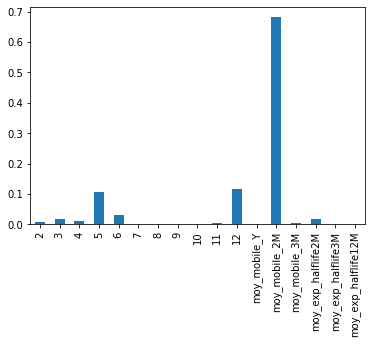

In [135]:
forest_importances = pd.Series(random_forest.feature_importances_,X.columns)
forest_importances.plot.bar()

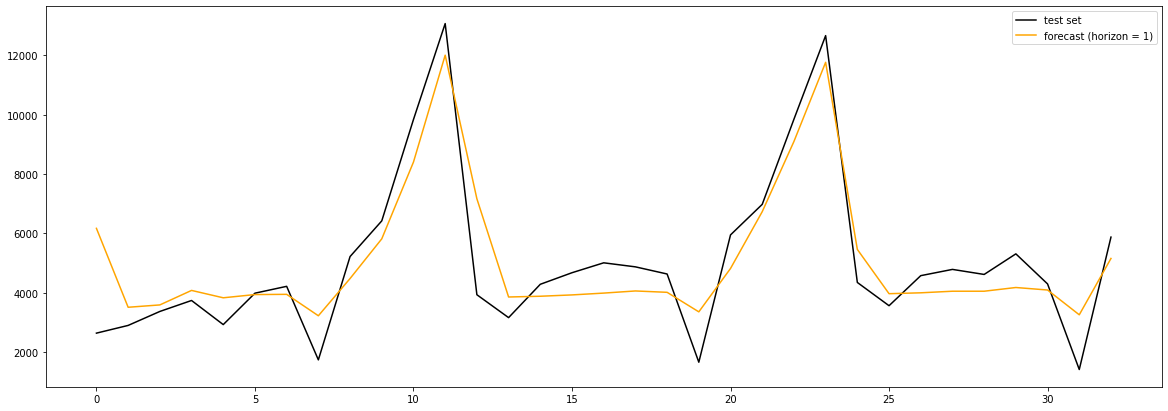

In [137]:
plt.figure(figsize = (20,7))
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA

### Code original (index numeriques)


In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:

from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)